In [3]:
# How does the water_content of the NEON soil package DP1.10107.001 change by date and soil horizon.

import requests
from datetime import datetime
import pandas as pd
import re
import plotly.express as px

In [4]:
# Get the Study ID for the NEON soil metagenome DP1.10107.001 project
base_url = "https://api.microbiomedata.org"
filt = "name.search:DP1.10107.001"
url = f"{base_url}/studies?filter={filt}"
resp = requests.get(url)
studies = resp.json()['results']
study_id = []
for study in studies:
    study_id.append(study['id'])
# Since there is only one value in the results, convert list to a string
study = ''.join(study_id)
print(study)

nmdc:sty-11-34xj1150


In [50]:
# Get all Biosamples from the NEON soil metagenomes (DP1.10107.001) study using the study identifier above

base_url = "https://api.microbiomedata.org"
# Maximum number of results allowed per page is 2000
per_page = 2000
# Specify the desired fields to be returned
fields = "fields=id,water_content,soil_horizon,collection_date.has_raw_value,elev,geo_loc_name.has_raw_value"
filt = f"part_of:{study}"
cursor = "*"
all_results = []

# Use cursor pagination to get results
while True:
    url = f"{base_url}/biosamples?filter={filt}&per_page={per_page}&cursor={cursor}&fields={fields}"
    resp = requests.get(url)
    data = resp.json()
    results = data["results"]
    cursor = data["meta"]["next_cursor"]
    all_results.extend(results)
    if not cursor:
        break

print(f"Total number of biosamples: {len(all_results)}")
print(all_results[:5])

Total number of biosamples: 4443
[{'collection_date': {'has_raw_value': '2016-07-26T01:30Z'}, 'elev': 677.6, 'id': 'nmdc:bsm-11-002vgm56', 'soil_horizon': 'O horizon', 'water_content': ['2.667 g of water/g of dry soil'], 'geo_loc_name': {'has_raw_value': 'USA: Alaska, Healy'}}, {'collection_date': {'has_raw_value': '2019-03-13T17:49Z'}, 'elev': 381.8, 'id': 'nmdc:bsm-11-00dkyf35', 'soil_horizon': 'M horizon', 'water_content': ['0.113 g of water/g of dry soil'], 'geo_loc_name': {'has_raw_value': 'USA: California, San Joaquin Experimental Range'}}, {'collection_date': {'has_raw_value': '2016-08-03T19:07Z'}, 'elev': 199.7, 'id': 'nmdc:bsm-11-00hrxp98', 'soil_horizon': 'O horizon', 'water_content': ['0.992 g of water/g of dry soil'], 'geo_loc_name': {'has_raw_value': 'USA: Massachusetts, Harvard Forest & Quabbin Watershed'}}, {'collection_date': {'has_raw_value': '2020-06-23T21:40Z'}, 'elev': 1649.3, 'id': 'nmdc:bsm-11-00m15h97', 'soil_horizon': 'M horizon', 'water_content': ['0.032 g of w

In [53]:
# Transform results to desired format and convert to a data frame
df_inp = []
no_water_content = []
water_content_units = "g of water/g of dry soil"
for biosamp in all_results:

    # Get only month, day, and year from collection_date (remove times)
    date = datetime.strptime(biosamp["collection_date"]["has_raw_value"],'%Y-%m-%dT%H:%MZ')
    date = date.strftime('%Y-%m-%d')
    
    # Remove sample where water_content is not given. Extract out units and convert to float
    if 'water_content' in biosamp:
        water_content = float("".join(biosamp["water_content"]).replace(water_content_units,""))

    rec = {"id": biosamp["id"],
           "collection_date": date,
           "soil_horizon": biosamp["soil_horizon"],
           "water_content": water_content,
          "elev": biosamp["elev"],
          "location": biosamp["geo_loc_name"]["has_raw_value"]}

    df_inp.append(rec)

df = pd.DataFrame(df_inp)

df   

,id,collection_date,soil_horizon,water_content,elev,location
0,nmdc:bsm-11-002vgm56,2016-07-26,O horizon,2.667,677.6,"USA: Alaska, Healy"
1,nmdc:bsm-11-00dkyf35,2019-03-13,M horizon,0.113,381.8,"USA: California, San Joaquin Experimental Range"
2,nmdc:bsm-11-00hrxp98,2016-08-03,O horizon,0.992,199.7,"USA: Massachusetts, Harvard Forest & Quabbin W..."
3,nmdc:bsm-11-00m15h97,2020-06-23,M horizon,0.032,1649.3,"USA: Colorado, Central Plains Experimental Range"
4,nmdc:bsm-11-00yhef97,2016-07-26,M horizon,0.032,44.8,"USA: Georgia, The Jones Center At Ichauway"
...,...,...,...,...,...,...
4438,nmdc:bsm-11-zy2p7j24,2018-07-17,M horizon,0.302,405.7,"USA: Kansas, Konza Prairie Biological Station"
4439,nmdc:bsm-11-zyh2rm11,2020-07-28,M horizon,0.399,405.4,"USA: Kansas, Konza Prairie Biological Station"
4440,nmdc:bsm-11-zyhk8g66,2017-06-21,M horizon,0.306,272.5,"USA: Tennessee, Oak Ridge"
4441,nmdc:bsm-11-zzdpcm17,2020-06-03,M horizon,0.283,260.1,"USA: Tennessee, Oak Ridge"


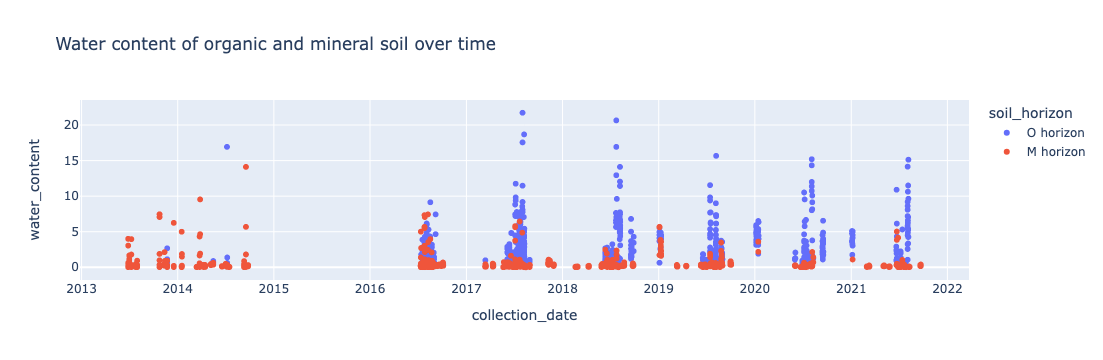

In [54]:
# Plot the water_content of all NEON sites over time for organic and mineral soil
fig = px.scatter(df, x="collection_date", y="water_content", color = "soil_horizon", title="Water content of organic and mineral soil over time")
fig.show()

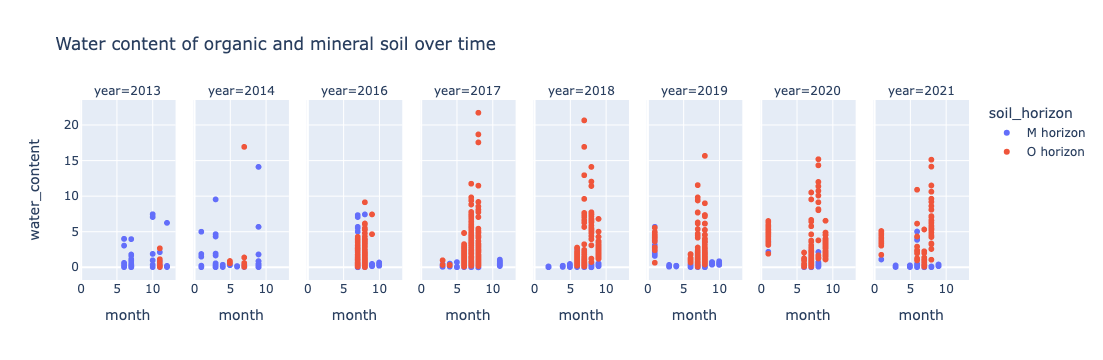

In [55]:
# Plot water content of Neon Sites over the course of each year 
df["collection_date"] = pd.to_datetime(df["collection_date"])
df = df.sort_values(by="collection_date")
df["year"] = df["collection_date"].dt.year
df["month"] = df["collection_date"].dt.month

fig = px.scatter(df, x="month", y="water_content", color = "soil_horizon", 
                 facet_col = "year", title="Water content of organic and mineral soil over time")
fig.show()

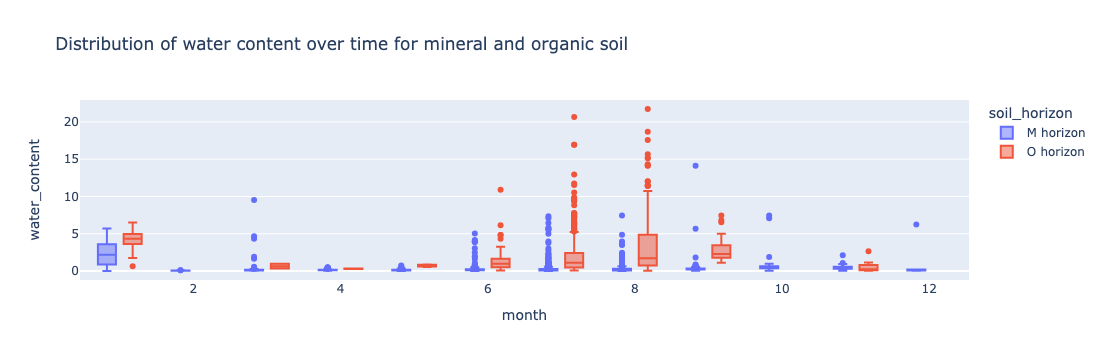

In [56]:
# Box and whisker plots
fig = px.box(df, x="month", y="water_content", color="soil_horizon", title="Distribution of water content over time for mineral and organic soil")
fig.show()

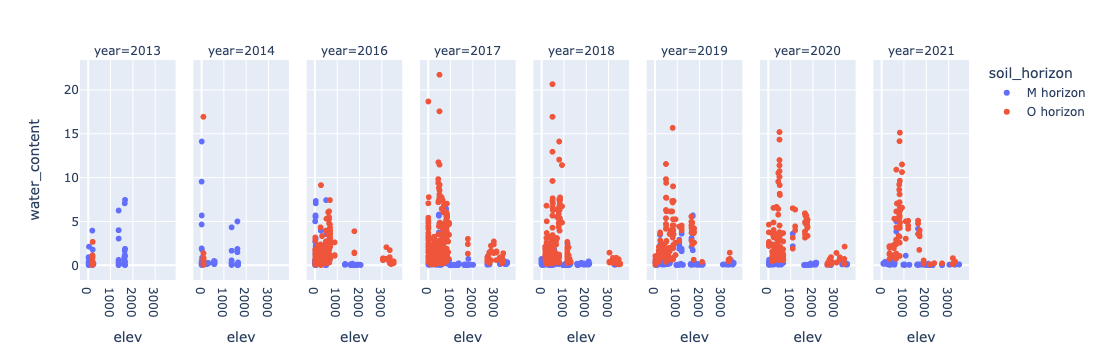

In [57]:
# Elevation and Water Content
fig = px.scatter(df, x="elev", y="water_content", color="soil_horizon", facet_col="year")
fig.show()

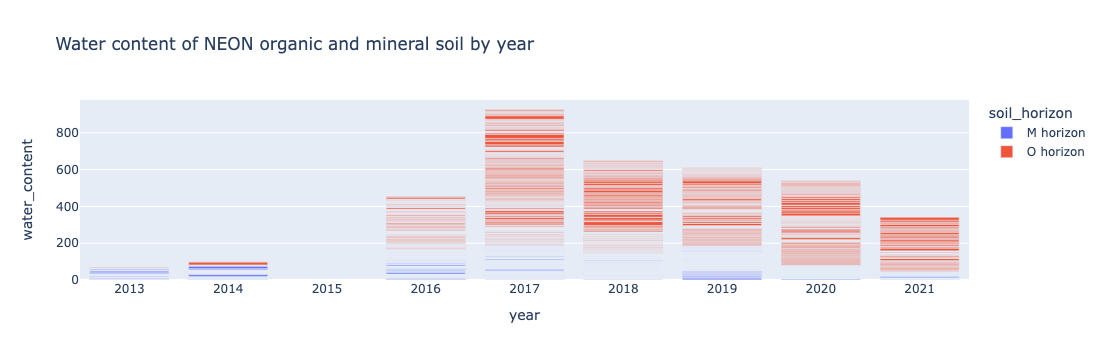

In [61]:
# Water Content and Soil Horizon
fig = px.bar(df, x="year", y="water_content", color="soil_horizon", title="Water content of NEON organic and mineral soil by year")
fig.show()

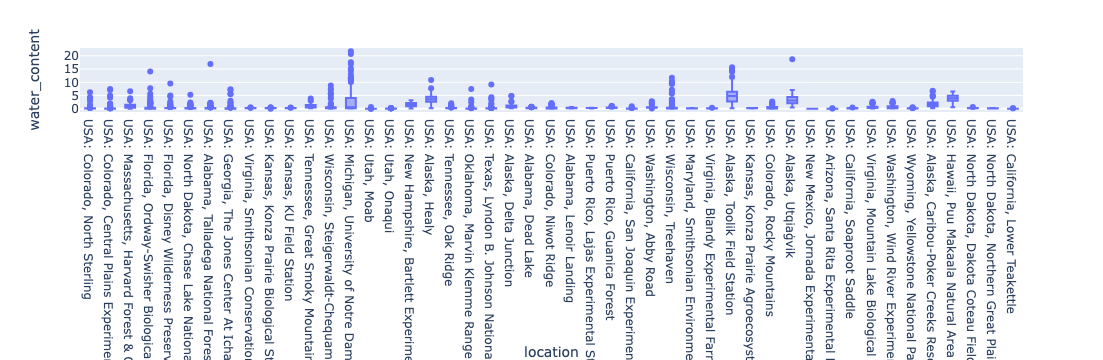

In [64]:
# # Box and whisker plots
fig = px.box(df, x="location", y="water_content")
fig.show()